# Figures from sequencing

notebook for generating figures for manuscript. Includes some level of processing of data from other notebooks, but no processing of raw sequencing data. Those are all relegated to other notebooks.

In [1]:
import pandas as pd
import glob 
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import math
from scipy import stats
from statsmodels.stats import multitest
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams.update({'font.size': 12, 'axes.titlesize':'medium',})
colormap = 'colorblind'
colors = sns.color_palette(colormap, 8)
#order not quite standard, has I want the HA and PB1 colors to be relatively distinct as those two segments will be discussed the most
segments = ['PB1_vRNA','HA_vRNA','PB2_vRNA',  'PA_vRNA','NP_vRNA','NA_vRNA','M_vRNA','NS_vRNA']
fluColors = {}
for color, segment in enumerate(segments):
    fluColors[segment] = colors[color]

twoColorPalette = [sns.color_palette('colorblind',8)[-2],sns.color_palette('dark', 8)[-1]]

figDir = 'Figures/'
supFigDir = 'SuppFigures/'
if not os.path.isdir(figDir):
    os.mkdir(figDir)
if not os.path.isdir(supFigDir):
    os.mkdir(supFigDir)

## Length polymorphic library

### load in data, variables

lets start with the length polymorphic libraries. Begin defining some variables and parameters.

In [2]:
segmentsOfInterest = ['HA_vRNA', 'PB1_vRNA']
lengths = {'PB1_vRNA':2341, 'HA_vRNA':1775}
#processed barcode counts
dataDirectory = "Sequencing/LengthPolymorph/"
#junction assignments from Mendes et al. 2021
priorData = 'PriorData/junctions/'


Load in datasets

In [3]:
sequencing = {'withNEP':[],'noNEP':[],'junctions':[]}
for file in glob.glob(dataDirectory + '*.tsv'):
    data = pd.read_csv(file, sep='\t')
    library = int(file.split('_')[-3])
    segment = file.split('_')[-4]
    if segment ==  'H':
        segment = 'HA_vRNA'
    else:
        segment = 'PB1_vRNA'
    dataset =file.split('_')[-2]
    data['segment'] = segment
    data['library'] = library
    sequencing[dataset] += [data]
for file in glob.glob(priorData + '*.tsv'):
    library = file.split('_')[-2]
    data = pd.read_csv(file, sep='\t')
    data['size'] = data.position_UP + data.position_DOWN 
    data['library'] = int(library)
    sequencing['junctions'] += [data]
for dataset in sequencing.keys():
    sequencing[dataset] = pd.concat(sequencing[dataset])

freqCalled = []
for key in sequencing:
    if key != 'junctions':
        sequencing[key] = sequencing['junctions'].merge(sequencing[key], how='right', on = ['barcode', 'segment','library'] )
        numCounts = sequencing[key].groupby(['library', 'segment'])['count'].sum().reset_index().rename(columns = {'count':'total'})
        sequencing[key] = sequencing[key].dropna()
        numFinal = sequencing[key].groupby(['library','segment'])['count'].sum().reset_index()
        numCounts = numCounts.merge(numFinal, on=['library', 'segment'])
        numCounts['experiment'] = key
        freqCalled += [numCounts]
freqCalled = pd.concat(freqCalled)

### Length-dependent phenomena

Show size distributions as a whole without granular analysis. Supplemental figure.

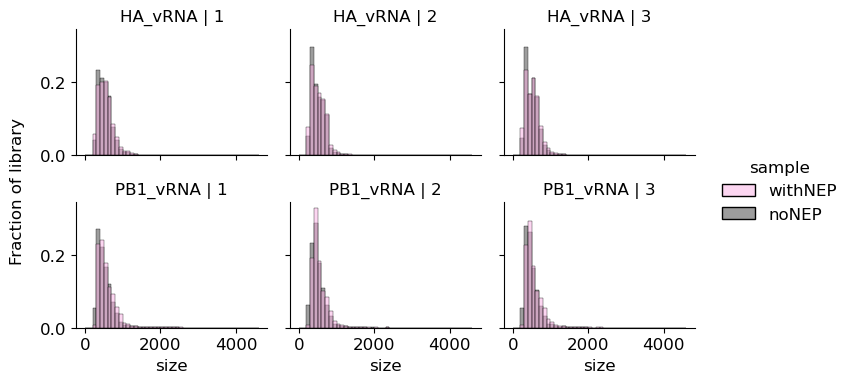

In [4]:
binsize = 100
withNEP = sequencing['withNEP'].copy()
withNEP['size'] = (withNEP['size']/binsize).apply(np.ceil) * binsize
withNEP = withNEP.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = withNEP.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
withNEP = withNEP.merge(sums, on = ['segment','library'] )
withNEP['fraction'] = withNEP['count']/withNEP['sum']
withNEP['sample'] = 'withNEP'

noNEP = sequencing['noNEP'].copy()
noNEP['size'] = (noNEP['size']/binsize).apply(np.ceil) * binsize
noNEP = noNEP.groupby(['size', 'segment', 'library']).sum().reset_index()[['size', 'segment', 'library', 'count']]
sums = noNEP.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size'])
noNEP = noNEP.merge(sums, on = ['segment','library'] )
noNEP['fraction'] = noNEP['count']/noNEP['sum']
noNEP['sample'] = 'noNEP'

bins = range(0, 4700,binsize)
g = sns.displot(data=pd.concat([withNEP,noNEP]), x='size',  col="library", hue='sample',palette=twoColorPalette, row='segment',
               alpha=0.5, weights = 'fraction', bins= bins, aspect= 1.2, height=2,
              )
g.set_titles(col_template="{col_name}", row_template="{row_name}")

g.set_axis_labels("size", " ")

g.fig.text(0.01, 0.5, 'Fraction of library', va='center', rotation='vertical')
plt.savefig(supFigDir + 'NS2distributionShift.pdf', format='pdf', bbox_inches = "tight")

Graph enrichment. Exclude positions with <100 counts in any replicate to reduce noise.

/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1307162783.py:4: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  counts = enrich.groupby(['segment', 'size']).count().reset_index()
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1307162783.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  enrich = enrich.merge(counts, on=['segment','size'], how='right')


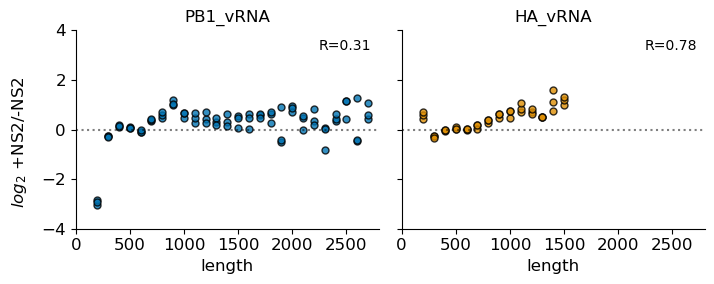

In [5]:
enrich = pd.concat([withNEP,noNEP]).pivot_table(index=['segment','size','library'], 
                                   columns=['sample'], values=['fraction','count']).reset_index().dropna()
enrich = enrich[ (enrich['count'].noNEP >= 100) & (enrich['count'].withNEP >= 100)]
counts = enrich.groupby(['segment', 'size']).count().reset_index()
counts = counts[counts.library == 3][['segment','size']]
enrich = enrich.merge(counts, on=['segment','size'], how='right')
enrich['enrichment'] = np.log2(enrich.fraction.withNEP/enrich.fraction.noNEP)

g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=enrich, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":25,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")

g.set(xlim=(0,2800))
g.set(ylim=(-4,4))

g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.set_axis_labels("length", " ")

g.fig.text(0.01, 0.5, '$log_{2}$ +NS2/-NS2', va='center', rotation='vertical')


axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    spearman = round(enrich[enrich.segment == ["PB1_vRNA", "HA_vRNA"][segment]][['enrichment','size']].corr('spearman')['enrichment']['size'],2)
    ax.text(0.8, 0.9, 'R=' + str(spearman.iloc[0]), transform=ax.transAxes, fontsize = 10)
plt.savefig('Figures/LengthPolyminigenomeEnrichmentBinned.pdf', format='pdf', bbox_inches = "tight")


Replicability for individual barcodes. Set a 100 threshold as you did for bundled data above. Good values for PB1, for HA perhaps driven by absence of selection.

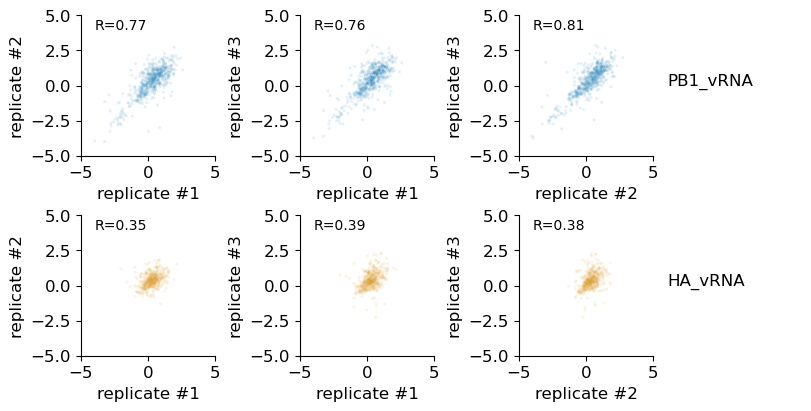

In [6]:
#combine barcodes into the same junction, but keep individual
NEP_individual = sequencing['withNEP'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
noNEP_individual = sequencing['noNEP'].copy().groupby(['segment','library','position_UP','position_DOWN','size']).sum().reset_index()[['segment','library','position_UP','position_DOWN','count','size']]
replicates = len(set(NEP_individual.library))

sums = NEP_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
NEP_individual = NEP_individual.merge(sums, on = ['segment','library'] )
NEP_individual['fraction'] = NEP_individual['count']/NEP_individual['sum']

sums = noNEP_individual.groupby(['segment','library']).sum().reset_index().rename(columns={'count':'sum'}).drop(columns=['size','position_UP','position_DOWN'])
noNEP_individual = noNEP_individual.merge(sums, on = ['segment','library'] )
noNEP_individual['fraction'] = noNEP_individual['count']/noNEP_individual['sum']
#enrichment
enrichment = noNEP_individual.merge(NEP_individual, on =['segment', 'library','position_UP','position_DOWN','size'], suffixes=['_noNEP','_NEP'])
enrichment = enrichment[(enrichment.count_NEP >= 50) &  (enrichment.count_noNEP >= 50)]

enrichment['enrichment'] = np.log2(enrichment.fraction_NEP/enrichment.fraction_noNEP)
enrichment['library'] = enrichment.library.astype(str)
enrichment = enrichment.pivot_table(index=['position_UP','position_DOWN','segment'], columns=['library'], values='enrichment').reset_index().dropna().drop(columns=['position_UP','position_DOWN'])
columns = int(math.factorial(replicates)/(2* math.factorial(replicates-2)))
rows = len(set(enrichment.segment))
height = 2
width = 2
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)

spec = g.add_gridspec(rows,columns +1)
for row, segment in enumerate(['PB1_vRNA','HA_vRNA']):
    numRep = 1
    currCol = 0
    first = False
    pearsonVal = enrichment[enrichment.segment == segment][['1','2','3']].corr()
    while numRep < replicates:
        comparison = numRep + 1
        
        while comparison <= replicates:
            if not first:
                ax = g.add_subplot(spec[row, currCol])
                firstAx = ax
                first = True
            else:
                ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
                
            sns.scatterplot(data=enrichment[enrichment.segment == segment], x=str(numRep), y=str(comparison), alpha=0.1, hue='segment', palette=fluColors,
                            legend=False, ax=ax, rasterized=True, s=5)
            sns.despine()
            ax.set_ylabel('replicate #' + str(comparison))
            ax.set_xlabel('replicate #' + str(numRep))
            ax.set_ylim(-5,5)
            ax.set_xlim(-5,5)
            Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
            ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
            comparison += 1
            currCol +=1
        ax = g.add_subplot(spec[row, currCol])
        ax.axis('off')
        ax.text(0.0, 0.5, segment, transform=ax.transAxes, fontsize=12)
        numRep +=1
        
        

plt.savefig(supFigDir + 'enrichmentLengthPolyPearson.pdf', format='pdf', bbox_inches = "tight")

For PB1, many barcodes are positively selected by NEP. Is length masking some phenomenon? Look at junction location instead.

First generate a set of junctions to assess, using (-) sense coordinates for all.

In [7]:
junctionList = {}
for segment in segmentsOfInterest:
    currFrame = sequencing['junctions'][sequencing['junctions'].segment == segment]
    junctionList[segment] = []
    junctionList[segment] += currFrame.position_UP.tolist()
    junctionList[segment] += (lengths[segment] - currFrame.position_DOWN).tolist()
    junctionList[segment] = set(junctionList[segment])
    

Assess per position. Do not bin sizes for this, compare equal sizes if present (else ignore)

In [8]:
noNEP = sequencing['noNEP'].copy()
noNEP['sample'] = 'noNEP'
withNEP = sequencing['withNEP'].copy()
withNEP['sample'] = 'withNEP'
currFrame = pd.concat([noNEP,withNEP])

currFrame['coordinate_DOWN'] =  currFrame.apply(lambda row:lengths[row.segment] - row.position_DOWN, axis=1)
sums = currFrame[['count','library','segment','sample']].groupby(['segment','library','sample']).sum().reset_index().rename(columns={'count':'sum'})
currFrame = currFrame.merge(sums, on = ['segment','library','sample'] )
currFrame['fraction'] = currFrame['count']/currFrame['sum']
output = []
for segment in junctionList:
    for position in junctionList[segment]:
        tempFrame = currFrame[currFrame.segment == segment].copy()
        tempFrame['positive'] = (tempFrame.position_UP >= position) | (tempFrame.coordinate_DOWN <= position)
        #there actually exist both
        if len(tempFrame[tempFrame.positive]) != 0 and len(tempFrame[tempFrame.positive]) != len(tempFrame):
            tempFrame = tempFrame.pivot_table(values = 'fraction', index=['segment','size','library','sample'], columns = ['positive'], aggfunc="sum").reset_index().dropna()
            tempFrame['enrichment'] = tempFrame[True]/tempFrame[False]
            tempFrame = tempFrame.pivot_table(values = 'enrichment', index=['segment','size','library'], columns = ['sample']).reset_index().dropna()
            tempFrame['enrichment'] = tempFrame.withNEP/tempFrame.noNEP
            #median value
            tempFrame = tempFrame.groupby(['segment','library'])['enrichment'].median().reset_index()
            tempFrame['position'] = position
            output += [tempFrame]

positions = pd.concat(output)
positions['enrichment'] = np.log2(positions.enrichment)

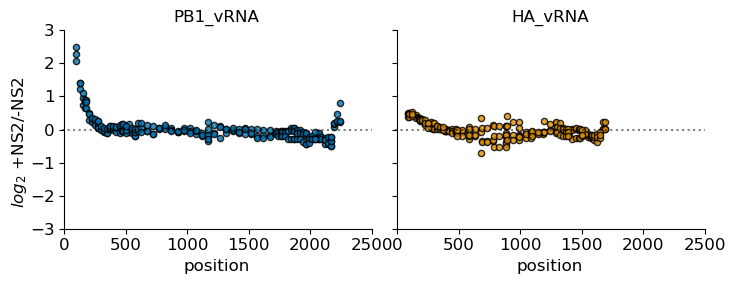

In [9]:

g = sns.lmplot(x="position", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=positions, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":20,'edgecolor':'k'})
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")

g.set_titles(col_template="{col_name}", row_template="{row_name}")


g.fig.text(0.01, 0.5, '$log_{2}$ +NS2/-NS2', va='center', rotation='vertical')

axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    ax.set_yticks(np.arange(-3,4,1))
    ax.set_xticks(np.arange(0,2600,500))
    ax.spines['left'].set_position('zero')

plt.ylim(-3,3)
plt.savefig('Figures/LengthPolyminigenomeEnrichmentPosition.pdf', format='pdf', bbox_inches = "tight")
 

For the position of high interest (100nt in PB1), is this still potentially a cryptic length-dependent phenomena? Look at lengths with and without that region, with and without NS2. Only retain observations where both conditions have >= 100 counts to reduce dispersion from low-confidence measurements.

In [10]:

binsize = 200
POI = 100
output = []
for segment in junctionList:

    graph = currFrame.loc[currFrame.segment == segment,]
    graph['size'] = (graph['size']/binsize).apply(np.ceil) * binsize
    graph['positive'] = (graph.position_UP >= POI) | (graph.coordinate_DOWN <= POI)
    graph = graph.pivot_table(values = ['fraction','count'], index=['segment','size','library','sample'], columns = ['positive'], aggfunc="sum").reset_index().dropna()
    graph = graph.loc[(graph['count'][False] >= 100) & (graph['count'][True] >= 100),]
    graph['enrichment'] = graph['fraction'][True]/graph['fraction'][False]
    graph = graph[['size','library','enrichment','sample','segment']]
    graph.columns = graph.columns.droplevel(1)
    restrict = graph.groupby(['size']).library.count().reset_index()
    restrict = restrict.loc[restrict.library == 6]
    graph = graph.merge(restrict['size'], on='size', how='inner')
    graph = graph.pivot_table(values = 'enrichment', index=['size','library','segment'], columns = ['sample']).reset_index().dropna()
    graph['enrichment'] = graph.withNEP/graph.noNEP

    graph['enrichment'] = np.log2(graph.enrichment)
    output += [graph]
graph = pd.concat(output)



/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1246138881.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['size'] = (graph['size']/binsize).apply(np.ceil) * binsize
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1246138881.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['positive'] = (graph.position_UP >= POI) | (graph.coordinate_DOWN <= POI)
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1246138881.py:7: SettingWithCopyWarning: 
A va

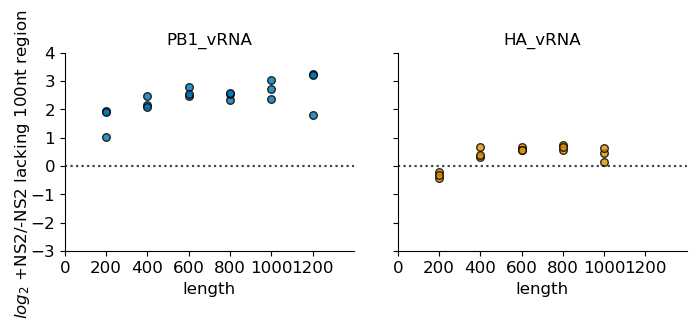

In [11]:

g = sns.lmplot(x="size", y="enrichment", col="segment", col_order=["PB1_vRNA", "HA_vRNA"], hue='segment', palette=fluColors,
               data=graph, fit_reg=False,aspect=1.2, height=3,scatter_kws={"s":30,'edgecolor':'k'})
axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    ax.spines['left'].set_position('zero')

    ax.set_yticks(np.arange(-3,5,1))
    ax.set_xticks(np.arange(0,1600,200))

g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(ylabel="")


g.set_axis_labels("length", " ")

g.fig.text(0.01, 0.5, '$log_{2}$ +NS2/-NS2 lacking 100nt region', va='center', rotation='vertical')
axes = g.fig.axes
for segment, ax in enumerate(axes):
    ax.axhline(y=0, color='k', linestyle=':',alpha=0.5)
    ax.set_yticks(np.arange(-3,5,1))
    ax.set_xticks(np.arange(0,1400,200))
    ax.spines['left'].set_position('zero')

plt.savefig(supFigDir + 'enrichmentLengthPoly100ntabsent.pdf', format='pdf', bbox_inches = "tight")

## Single nucleotide mutation library

### load in data, variables

Loading in data from amplicon and SNP. Handled slighty different, aligned

In [51]:
dataFolder = 'Results/SNPcounts'

#adjust coordinates for adapters
posAdjustAmplicon = 14
posAdjustRACE = 30
PB1delLength = 562



In [52]:
data = []
for file in glob.glob('Results/SNPcounts/*.tsv'):
    baseName = os.path.basename(file)
    if baseName.split('_')[0] == 'RACE':
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0].split('_')[1]
        currData['replicate'] = baseName.split('-')[1][0]
        currData['position'] = currData['position']-posAdjustRACE
        currData['sequencing'] = 'RACE'
        #only use to infer to first and last 20 nt
        currData = currData[(currData['position'] <= 20) | (currData['position'] > PB1delLength - 20)]
        data += [currData]

    else:
        currData = pd.read_csv(file, sep = '\t')
        currData['category'] = baseName.split('-')[0]
        currData['replicate'] = baseName.split('-')[1][0]
        currData['position'] = currData['position']-posAdjustAmplicon
        currData['sequencing'] = 'amplicon'
        #exclude first and last 20 nt
        currData = currData[(currData['position'] > 20) & (currData['position'] <=PB1delLength - 20)]
        data += [currData]
data = pd.concat(data)
data = data.loc[(data.position > 0) & (data.position <= PB1delLength)]


Depth for amplicons

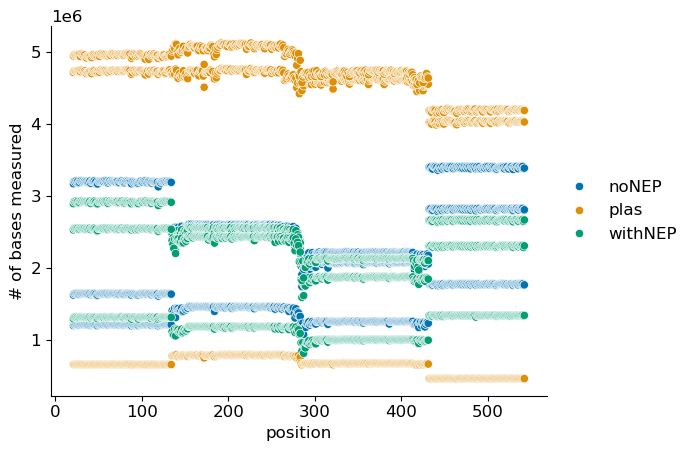

In [53]:
ax = sns.scatterplot(y=data[data.sequencing=='amplicon'][['A','G','C','T']].sum(axis=1), x=data[data.sequencing=='amplicon'].position, hue=data[data.sequencing=='amplicon'].category, palette = 'colorblind')
sns.despine()
plt.ylabel('# of bases measured')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.savefig(supFigDir + 'SNPdepthAmplicon.pdf', format='pdf', bbox_inches = "tight")

Depth for RACE broken axis as a bit silly to view from afar. Occasional drops will be due to quality scores. or indels

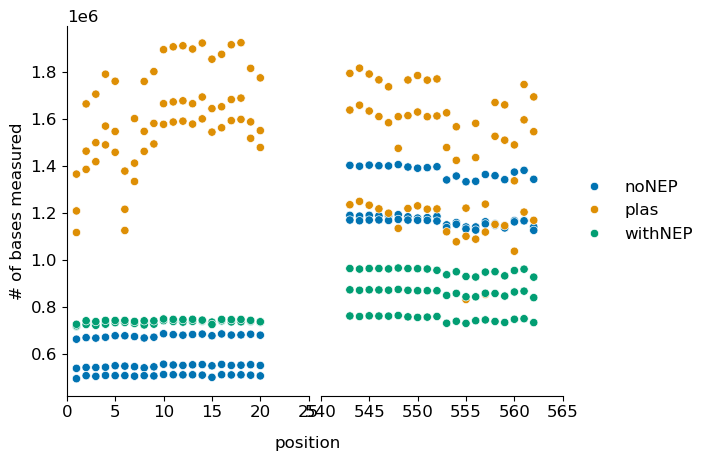

In [65]:
f, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, sharey=True)
ax = sns.scatterplot(y=data[data.sequencing=='RACE'][['A','G','C','T']].sum(axis=1), x=data[data.sequencing=='RACE'].position, hue=data[data.sequencing=='RACE'].category, palette = 'colorblind',
                    ax=ax1)
ax = sns.scatterplot(y=data[data.sequencing=='RACE'][['A','G','C','T']].sum(axis=1), x=data[data.sequencing=='RACE'].position, hue=data[data.sequencing=='RACE'].category, palette = 'colorblind',
                    ax=ax2)
ax1.set_xlim(0,21)
ax2.set_xlim(541,563)
sns.despine()
ax2.spines['left'].set_visible(False)
ax1.get_legend().remove()
ax2.tick_params(left = False) 
ax1.set_ylabel('# of bases measured')
ax1.set_xticks(np.arange(0,30,5))
ax2.set_xticks(np.arange(540,570,5))
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.subplots_adjust(wspace=0.05, hspace=0)
f.text(0.45, 0.01, 'position', va='center', rotation='horizontal')
ax1.set_xlabel('')
ax2.set_xlabel('')

plt.savefig(supFigDir + 'SNPdepthRACE.pdf', format='pdf', bbox_inches = "tight")

Plasmid data only realy usefull for inferring initial error rate, do so now. Stick to amplicons rather than RACE. The plasmid sequencing actually lacks good reads on first and last 13 nt

/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1195987434.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['majorityVariant'] = graph[['A','G','C','T']].idxmax(axis=1)
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1195987434.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph['totalDepth'] = graph[['A','G','C','T']].sum(axis=1)
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1195987434.py:11: SettingWithCopyWarning: 
A value is trying to b

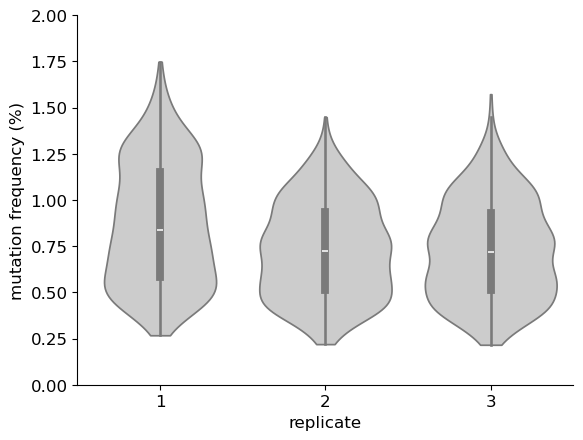

In [56]:
graph = data.loc[(data.category == 'plas') ]
graph['majorityVariant'] = graph[['A','G','C','T']].idxmax(axis=1)
graph['totalDepth'] = graph[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  (1 - (row[column]/row.totalDepth)) * 100
    else:
        return 0

graph['minorityFreq'] = graph.apply(lambda row: minorityVariant(row), axis=1)
sns.violinplot(data=graph, x="replicate", y="minorityFreq", cut=0, color ='0.8')
plt.ylim(0,2)
sns.despine()
plt.ylabel('mutation frequency (%)')
plt.savefig(supFigDir + 'mutationFreqplasmid.pdf', format='pdf', bbox_inches = "tight")

Transform all values to - coordinates, as they are in full-length. Also go ahead and label significance of nucelotides.

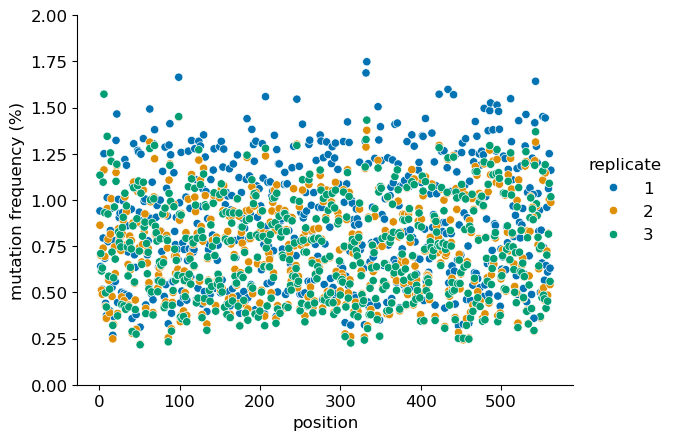

In [64]:
ax = sns.scatterplot(y=graph.minorityFreq, x=graph.position, hue=graph.replicate, palette = 'colorblind')
sns.despine()
plt.ylim(0,2)
plt.ylabel('mutation frequency (%)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='replicate')
plt.savefig(supFigDir + 'mutationFreqplasmidPos.pdf', format='pdf', bbox_inches = "tight")

Wild-type is majority in all positions, so can just infer from max observed

In [95]:
data['majorityVariant'] = data[['A','G','C','T']].idxmax(axis=1)
data['totalDepth'] = data[['A','G','C','T']].sum(axis=1)
def minorityVariant(row):
    column = row.majorityVariant
    if row.totalDepth != 0:
        return  1 - (row[column]/row.totalDepth)
    else:
        return 0

data['minorityFreq'] = data.apply(lambda row: minorityVariant(row), axis=1)
data = data.loc[(data.category == 'noNEP') | (data.category == 'withNEP'),]

Load in just relevant data.

Convert to full-length coordiantes, - sense.

Calculate ratios

Calculate pval using 1-sample t-test on log-transformed ratios with a null expectition of 0

Collapse to mean values and calculate qvalue for FDR

In [222]:
allPoints = data.pivot_table(index=['position', 'replicate'], columns='category', values='minorityFreq').reset_index()
allPoints['enrichment'] = np.log2(allPoints.withNEP/allPoints.noNEP)
allPoints['pval'] = allPoints.apply(lambda row: stats.ttest_1samp(allPoints[allPoints.position == row.position].enrichment, popmean=0)[1], axis =1 )

PB1length = 2341
allPoints['context'] = 'CDS'
allPoints.loc[allPoints.position <= 24, 'context'] = '3\' UTR'
allPoints.loc[allPoints.position <= 12, 'context'] = 'U12'
allPoints.loc[allPoints.position >= 519, 'context'] = '5\' UTR'
allPoints.loc[(allPoints.position >= 542) & (allPoints.position <= 547), 'context'] = 'polyA'

allPoints.loc[allPoints.position >= 550, 'context'] = 'U13'
#fix position in positive then invert
junctionLastBase = 385
otherSideExclude = 2164

allPoints['FullLengthPos'] = allPoints.position
allPoints.loc[allPoints.position > 385, 'FullLengthPos'] = allPoints.loc[allPoints.position > 385].FullLengthPos + otherSideExclude -junctionLastBase 
#now invert
allPoints['FullLengthPos'] = PB1length - allPoints.FullLengthPos + 1


#combine measurements for appropriate qval and some graphing
freqCompare = allPoints[['FullLengthPos','pval','enrichment','context']].groupby(['FullLengthPos','context']).mean().reset_index()
freqCompare['qval'] =  multitest.multipletests(freqCompare.pval, alpha=0.1, method='fdr_bh', is_sorted=False, returnsorted=False)[1]
freqCompare['significant'] = freqCompare.qval < 0.1

Plot of mean values observed at each position.

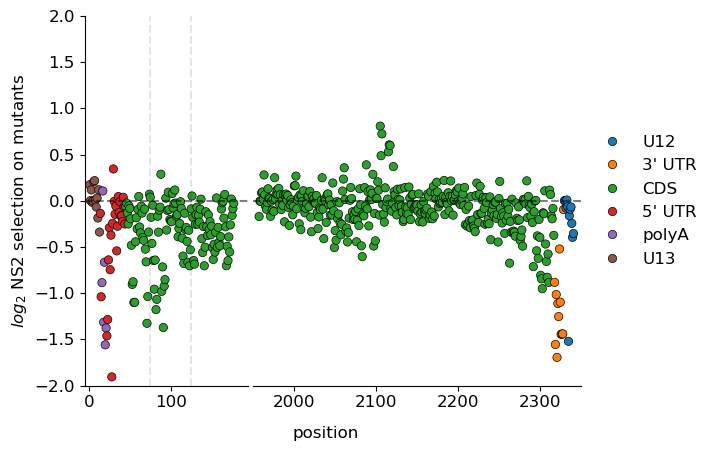

In [251]:
f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1, 2]}, sharey=True)

ax = sns.scatterplot(data = freqCompare, x='FullLengthPos', y='enrichment', hue='context',hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'],edgecolor='k', ax=ax1)

ax = sns.scatterplot(data = freqCompare, x='FullLengthPos', y='enrichment', hue='context',hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'], edgecolor='k',ax=ax2)

ax1.set_xlim(-5,195)
ax2.set_xlim(1950,2350)

sns.despine()
ax2.spines['left'].set_visible(False)
ax1.get_legend().remove()
ax2.tick_params(left = False) 
ax1.set_ylabel('$log_{2}$ NS2 selection on mutants')

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.subplots_adjust(wspace=0.02, hspace=0)
ax1.set_xlabel('')
ax2.set_xlabel('')

plt.ylim(-2,2)

ax1.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
ax2.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
f.text(0.45, 0.01, 'position', va='center', rotation='horizontal')
ax1.axvline(x=75, color = 'k',ls = '--', alpha =0.1)
ax1.axvline(x=125, color = 'k',ls = '--', alpha =0.1)

plt.savefig('Figures/SNPcoordSelectionNoStat.pdf', format='pdf', bbox_inches = "tight")


Zoom in, and highlight significant regions.

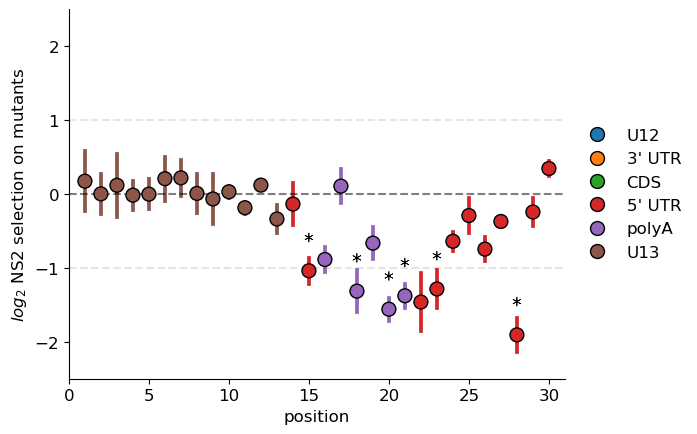

In [269]:
freqCompare['significant'] = freqCompare.significant & (abs(freqCompare.enrichment) >= 1)
freqCompare['sigGraph'] = freqCompare.enrichment + 0.45

graph = allPoints.merge(freqCompare[['FullLengthPos','significant']], on='FullLengthPos')
ax = sns.pointplot(data=graph[(graph.FullLengthPos <= 30)], x='FullLengthPos', y='enrichment', hue='context', hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'],  errorbar='sd', linestyle='none', native_scale=True, legend=False)

sns.scatterplot(data = freqCompare[(freqCompare.FullLengthPos <= 30) & (freqCompare.significant)], x='FullLengthPos', y='sigGraph',style='significant', markers = {True:(6,2,0), False:(6,2,0)}, color='0',ax=ax, s=40, legend=False)
sns.scatterplot(data = freqCompare[(freqCompare.FullLengthPos <= 30) ], x='FullLengthPos', y='enrichment', hue='context', hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'], edgecolor=
            'k',s=100,zorder=2.5, linewidth=1)

ax.set_xlim(0,31)

ax.axhline(y=1, color = 'k',ls = '--', alpha =0.1)
ax.axhline(y=-1, color = 'k',ls = '--', alpha =0.1)
sns.despine()
plt.ylim(-2.5,2.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_ylabel('$log_{2}$ NS2 selection on mutants')
plt.xlabel('position')
plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
plt.savefig('Figures/NEPvRNAprom.pdf',format='pdf', bbox_inches = "tight")

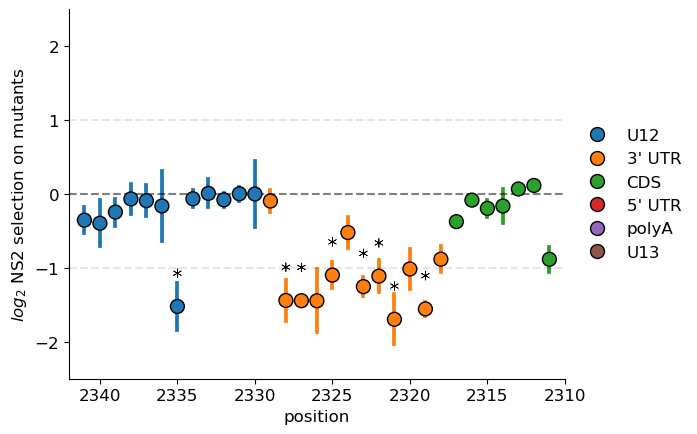

In [270]:
ax = sns.pointplot(data=graph[(graph.FullLengthPos >= 2311)], x='FullLengthPos', y='enrichment', hue='context', hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'],  errorbar='sd', linestyle='none', native_scale=True, legend=False)
sns.scatterplot(data = freqCompare[(freqCompare.FullLengthPos >= 2311) & (freqCompare.significant)], x='FullLengthPos', y='sigGraph',style='significant', markers = {True:(6,2,0), False:(6,2,0)}, color='0',ax=ax, s=40, legend=False)
sns.scatterplot(data = freqCompare[(freqCompare.FullLengthPos >= 2311) ], x='FullLengthPos', y='enrichment', hue='context', hue_order=['U12','3\' UTR','CDS','5\' UTR', 'polyA','U13'], edgecolor=
            'k',s=100,zorder=2.5, linewidth=1)
ax.set_xlim(0,40)


ax.axhline(y=1, color = 'k',ls = '--', alpha =0.1)
ax.axhline(y=-1, color = 'k',ls = '--', alpha =0.1)
ax.axis([2342, 2310, -2, 2])
sns.despine()
plt.ylim(-2.5,2.5)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
ax.set_ylabel('$log_{2}$ NS2 selection on mutants')
plt.xlabel('position')
plt.axhline(y=0, color = 'k',ls = '--', alpha =0.5)
plt.savefig('Figures/NEPcRNAprom.pdf',format='pdf', bbox_inches = "tight")

Last but not least, do data between replicates tend to correlate.

/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1591656317.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tempFrame, x=str(numRep), y=str(comparison), alpha=0.1, palette=fluColors['PB1_vRNA'],
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1591656317.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tempFrame, x=str(numRep), y=str(comparison), alpha=0.1, palette=fluColors['PB1_vRNA'],
/var/folders/5v/n_drd4992tz9ydg66x78mpm00000gn/T/ipykernel_19896/1591656317.py:25: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=tempFrame, x=str(numRep), y=str(comparison), alpha=0.1, palette=fluColors['PB1_vRNA'],


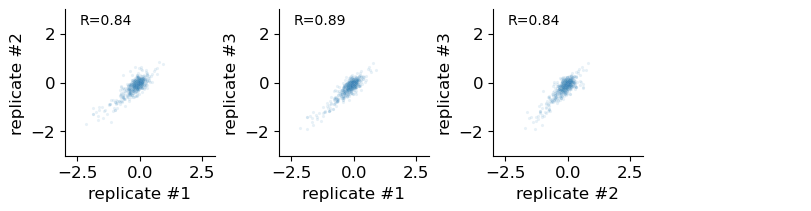

In [250]:
height = 2
width = 2
columns = 3
rows = 1
g= plt.figure(1,(width*(columns+1),rows*height), constrained_layout=True)
tempFrame = graph.pivot_table(values = 'enrichment', index=['position'], columns = ['replicate']).reset_index().dropna()
replicates = 3
spec = g.add_gridspec(rows,columns +1)
numRep = 1
currCol = 0
first = False
pearsonVal = tempFrame[['1','2','3']].corr()
row = 0
while numRep < replicates:
    comparison = numRep + 1
    
    while comparison <= replicates:
        if not first:
            ax = g.add_subplot(spec[row, currCol])
            firstAx = ax
            first = True
        else:
            ax = g.add_subplot(spec[row,currCol], sharey = firstAx, sharex= firstAx)
            
        sns.scatterplot(data=tempFrame, x=str(numRep), y=str(comparison), alpha=0.1, palette=fluColors['PB1_vRNA'],
                        legend=False, ax=ax, rasterized=True, s=5)
        sns.despine()
        ax.set_ylabel('replicate #' + str(comparison))
        ax.set_xlabel('replicate #' + str(numRep))
        ax.set_ylim(-3,3)
        ax.set_xlim(-3,3)
        Rval = round(pearsonVal[str(numRep)].iloc[comparison-1],2)
        ax.text(0.1, 0.9, 'R=' + str(Rval), transform=ax.transAxes, fontsize = 10)
        comparison += 1
        currCol +=1
    ax = g.add_subplot(spec[row, currCol])
    ax.axis('off')
    numRep +=1
    
        

plt.savefig(supFigDir + 'SNPPearson.pdf', format='pdf', bbox_inches = "tight")